# Imports

In [130]:
import os
import numpy as np
import pandas as pd
from unidecode import unidecode
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import seaborn as sns
from google.cloud import storage
from ydata_profiling import ProfileReport

import warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
pd.set_option('display.max_columns', 100)

## Funções auxiliares

In [368]:
def get_data(bucket_name:str, imobiliarias:str = ['apolar', 'cilar'],by:str = ['date','date_diff'], dates:list = [], date_diff:int = 2):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    files_on_bucket = [i.name for i in bucket.list_blobs()]
    files = pd.DataFrame(files_on_bucket, columns=['name'])
    files['date'] = pd.to_datetime(files['name'].apply(lambda f: f.split(' - ')[0]))
    files['imobiliaria'] = files['name'].apply(lambda f: f.split(' - ')[-1].replace('.csv',''))

    match by:
        case 'date':
            files = files.loc[files['date'].isin(dates)]
            files = files.loc[files['imobiliaria'].isin(imobiliarias)]
        case 'date_diff':
            dates = files['date'].sort_values(ascending=False).drop_duplicates().reset_index(drop=True)[:date_diff].tolist()
            files = files.loc[files['date'].isin(dates)]
            files = files.loc[files['imobiliaria'].isin(imobiliarias)]
    
    df_full = pd.DataFrame()

    for file_name in files['name'].tolist():
        try:
            df_aux = pd.read_csv(f'gs://{bucket_name}/{file_name}')
            df_full = pd.concat([df_full, df_aux], axis = 0)
        except:
            pass

    df_full = df_full.reset_index(drop=True)

    return df_full

def barplot(title:str, group:str, agg:str, agg_name:str, data:pd.DataFrame, agg_func:str, title_font_size:int =10, figure= plt.figure, figsize=(10,5), label=True, sort: bool = True):
    
    # group data
    aux = data[[group,agg]].groupby(group).agg(agg_func).reset_index().rename(columns={agg:agg_name})

    if sort:
        aux = aux.sort_values(agg_name, ascending=False)
        
    # plot
    figure(figsize)

    # plot configs
    plt.title(title, fontsize=title_font_size)
    plt.xticks(rotation = 45)

    # figure
    g = sns.barplot(x = group, y = agg_name, data = aux)

    if label:
        for i in g.containers:
            g.bar_label(i, color = 'white',label_type='center')
    else:
        pass

def histplot(title:str, col:str, data:pd.DataFrame, figsize=(10,5), label=True):

    plt.figure(figsize=figsize)
    plt.title(title)
    g = sns.histplot(x = col,  data = data)
    plt.xticks(rotation = 45)
    if label:
        for i in g.containers:
            g.bar_label(i, color = 'white',label_type='center')
    else:
        pass

def get_infos_curitiba():

    import pandas as pd
    import requests
    import bs4

    ## Request site
    response = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Curitiba')

    ## beautiful soup object
    soup = bs4.BeautifulSoup(response.content, 'html.parser')

    # tabelas da wikipedia
    infos_tabela = soup.findAll('table', {'class','wikitable'})

    bairros_info_list = []

    ## para cada tabela
    for tabela in infos_tabela:

        # colunas
        columns = [i.text.replace('\n','') for i in tabela.findAll('th')]

        # valores da tabela
        table_values = [i.text.replace('\xa0','').replace('\n','') for i in tabela.findAll('td')][1::]
        table_values_list = [] 
        for i in range(0,len(table_values),7): 
            table_values_list.append(table_values[i:i+7])

        # preenchenco dicionário
        for b in table_values_list:

            bairros_info_dict = {}

            bairros_info_dict['Bairro'] = b[0]
            bairros_info_dict['Área (km²)'] = b[1].replace(',','.')
            bairros_info_dict['Homens'] = b[2].replace(',','.')
            bairros_info_dict['Mulheres'] = b[3].replace(',','.')
            bairros_info_dict['Total'] = b[4].replace(',','.')
            bairros_info_dict['Domicilios particulares'] = b[5].replace(',','.')
            bairros_info_dict['Rendimento mensal médio porresponsáveis dos domicílios (R$)'] = b[6].replace(',','.')

            bairros_info_list.append(bairros_info_dict)
    
    return pd.DataFrame(bairros_info_list)

# Carregando Dados

In [637]:
df_full = get_data(
    bucket_name='busca-apartamentos-trusted',
    by='date',
    dates=['2024-03-10']
)

In [684]:
df = df_full

# Descrição dos Dados

In [685]:
df.describe()

,aluguel,condominio,seguro_incendio,iptu,area,quartos,suites,banheiros,vagas_garagem
count,793.000000,740.000000,794.000000,615.000000,793.000000,792.000000,514.000000,687.000000,737.000000
mean,2204.477680,629.196338,12.971990,111.995805,91.563682,2.087121,0.509728,1.248908,0.397558
std,1607.443576,375.319750,16.503754,111.460343,62.058390,0.831574,0.615668,0.677025,0.539872
min,560.000000,0.010000,0.000000,11.110000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1350.000000,400.000000,0.000000,49.080000,52.000000,1.000000,0.000000,1.000000,0.000000
50%,1800.000000,527.905000,0.000000,75.000000,74.000000,2.000000,0.000000,1.000000,0.000000
75%,2500.000000,748.080000,26.260000,127.355000,110.000000,3.000000,1.000000,1.000000,1.000000
max,20000.000000,3189.700000,87.580000,874.000000,434.000000,4.000000,3.000000,5.000000,3.000000


## Tratando NAs

In [686]:
df.isna().sum()

site                        0
titulo                      1
link                        0
data_coleta                 0
endereco                    1
atributos                 470
descricao                 470
bairro                      1
cidade                      1
aluguel                     1
condominio                 54
seguro_incendio             0
iptu                      179
area                        1
quartos                     2
suites                    280
banheiros                 107
vagas_garagem              57
mobiliado                   1
piscina                     1
academia                    1
sacada                      1
churrasqueira               1
salao_de_festas             1
catacteristicas_imovel    326
detalhes_condominio       385
dtype: int64

### Removendo NAs

In [687]:
# Removendo nulos da coluna título
# Requests mal sucedidas
df = df.dropna(subset=['titulo'])
df = df.loc[df['titulo'] != 'ref.']
df = df.loc[((~ df['descricao'].isna()) & (df['site'] == 'Apolar')) | ((~ df['catacteristicas_imovel'].isna()) & (df['site'] == 'Cilar'))]

In [688]:
df.shape

(792, 26)

### Preenchendo NAs

In [689]:
# Quando não há valor do condomínio, entende-se que o valor está incluso no aluguel
df.loc[:,'condominio'] = df['condominio'].fillna(0)

# Quando não há valor do iptu, entende-se que o valor está incluso no aluguel
df.loc[:,'iptu'] = df['iptu'].fillna(0)

In [690]:
# # Quando vazio, faz-se uma busca na descrição do imóvel, se encontrado, coloca-se como pelo menos 1 banheiro
df.loc[df['suites'].isna(),'suites'] = df.loc[df['suites'].isna(),'descricao'].apply(lambda x: np.nan if isinstance(x,float) else 1 if 'suite' in unidecode(x.lower()) else 0)

# # Quando vazio, faz-se uma busca na descrição do imóvel, se encontrado, coloca-se como pelo menos 1 banheiro
df.loc[df['banheiros'].isna(),'banheiros'] = df.loc[df['banheiros'].isna(),'descricao'].apply(lambda x: np.nan if isinstance(x,float) else 1 if 'banheiro' in unidecode(x.lower()) else np.nan)

# # Quando vazio, significa que não há vagas
df.loc[:,'vagas_garagem'] = df['vagas_garagem'].fillna(0)


### Preenchendo valores zerados

In [692]:
# # Quando vazio, significa que não há vagas
df.loc[df['quartos'] == 0,'quartos'] = df.loc[df['quartos'] == 0,'catacteristicas_imovel'].apply(lambda x: np.nan if isinstance(x,float) else 1 if 'dormitorio' in unidecode(x.lower()) else 0)

# # Quando vazio, significa que não há vagas
df.loc[df['banheiros'] == 0,'banheiros'] = df.loc[df['banheiros'] == 0,'catacteristicas_imovel'].apply(lambda x: np.nan if isinstance(x,float) else 1 if 'bwc' in unidecode(x.lower()) else 0)

# # Quando vazio, significa que não há vagas
# df.loc[df['vagas_garagem'] == 0,'vagas_garagem'] = df.loc[df['vagas_garagem'] == 0,'catacteristicas_imovel'].apply(lambda x: np.nan if isinstance(x,float) else 1 if 'vaga' in unidecode(x.lower()) else 0)

## Ajustes 

In [693]:
df['bairro'] = df['bairro'].str.strip()
df['bairro'] = df['bairro'].replace('Ecoville','Mossungue').replace('Champagnat','Bigorrilho')


## Mudando tipos de Dados

# Features Engineering

### Infos dos bairros

In [694]:
# infos_curitiba = get_infos_curitiba()
# infos_curitiba['Bairro'] = infos_curitiba['Bairro'].apply(lambda x: unidecode(x).capitalize().strip())
# infos_curitiba[[ 'Área (km²)', 'Homens', 'Mulheres', 'Total', 'Domicilios particulares', 'Rendimento mensal médio porresponsáveis dos domicílios (R$)']] = infos_curitiba[[ 'Área (km²)', 'Homens', 'Mulheres', 'Total', 'Domicilios particulares', 'Rendimento mensal médio porresponsáveis dos domicílios (R$)']].astype('float64')
# df = pd.merge(df, infos_curitiba, left_on = 'bairro', right_on = 'Bairro', how = 'left')

### Valor total

In [696]:
# valor total
df.loc[:,'valor_total'] = df['aluguel'] + df['condominio'] + df['seguro_incendio'] + df['iptu']

### Preco m²

In [697]:
df['preco_metro_2'] = df[['area','valor_total']].apply(lambda x: np.nan if x['area'] < 2 else x['valor_total']/x['area'], axis = 1).astype('float')

# Filtrando variáveis

In [698]:
df = df.dropna(subset=['preco_metro_2'])

# Análise Exploratória

## Análise Univariada

### Variável resposta

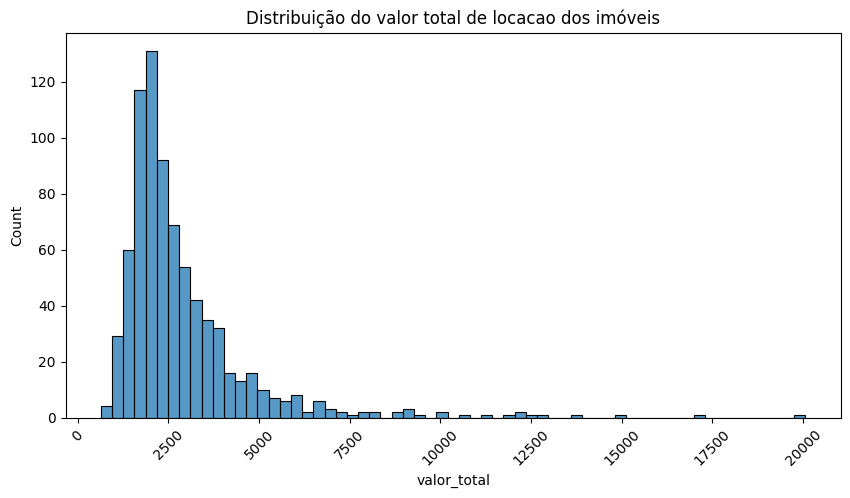

In [699]:
histplot('Distribuição do valor total de locacao dos imóveis',
         col = 'valor_total',
         data = df,
         figsize=(10,5),
         label = False)

### Variáveis Numéricas

In [700]:
df.columns

Index(['site', 'titulo', 'link', 'data_coleta', 'endereco', 'atributos',
       'descricao', 'bairro', 'cidade', 'aluguel', 'condominio',
       'seguro_incendio', 'iptu', 'area', 'quartos', 'suites', 'banheiros',
       'vagas_garagem', 'mobiliado', 'piscina', 'academia', 'sacada',
       'churrasqueira', 'salao_de_festas', 'catacteristicas_imovel',
       'detalhes_condominio', 'valor_total', 'preco_metro_2'],
      dtype='object')

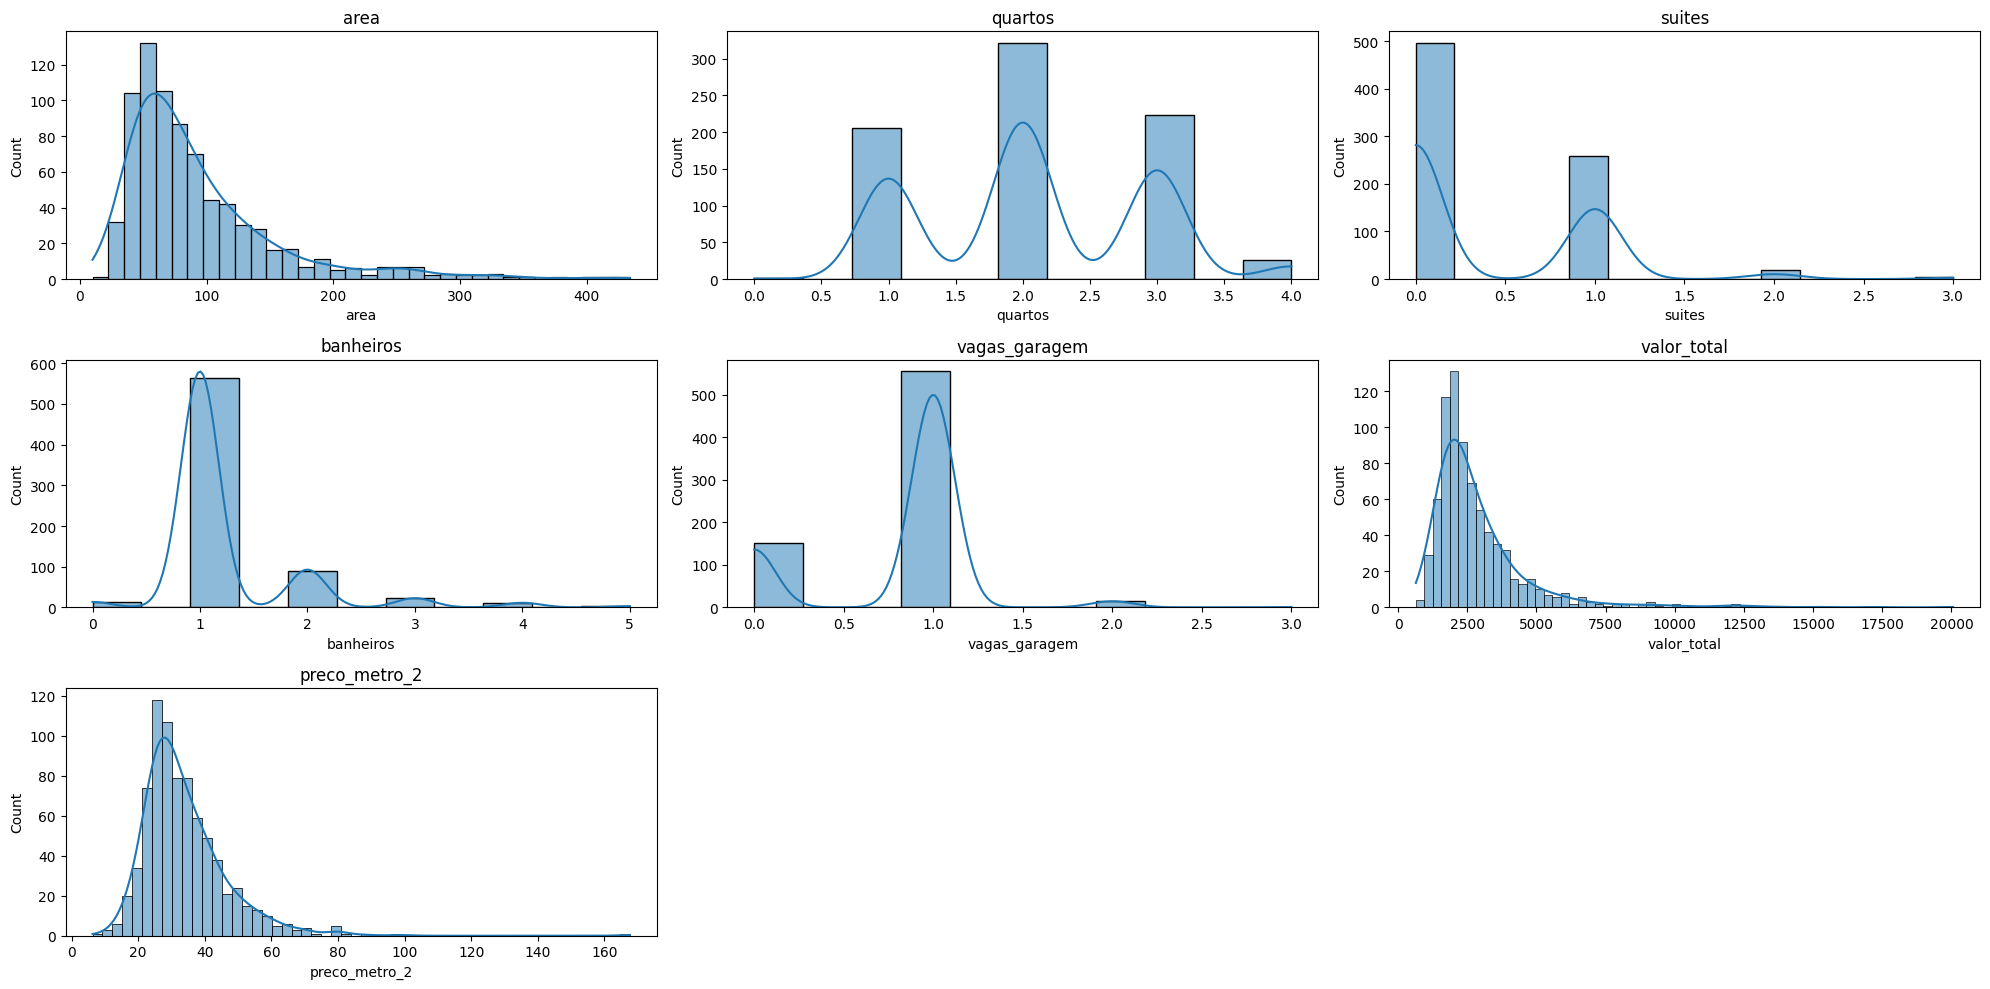

In [701]:
from matplotlib import gridspec as gridspec
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

rows = 3
cols = 3

columns = [
 'area',
 'quartos',
 'suites',
 'banheiros',
 'vagas_garagem',
#  'Área (km²)',
#  'Homens',
#  'Mulheres',
#  'Total',
#  'Domicilios particulares',
#  'Rendimento mensal médio porresponsáveis dos domicílios (R$)',
 'valor_total',
 'preco_metro_2']

grid = gridspec.GridSpec(rows,cols);
plt.figure(figsize=(20,10));
elem = 0

for i in range(rows):
    for j in range(cols):

        plt.subplot(grid[i,j]);
        plt.title(columns[i*rows+j])
        sns.histplot(df[columns[i*rows+j]], kde=True);

        elem += 1
        if elem == len(columns):
            break

plt.tight_layout()

### Variáveis Categóricas

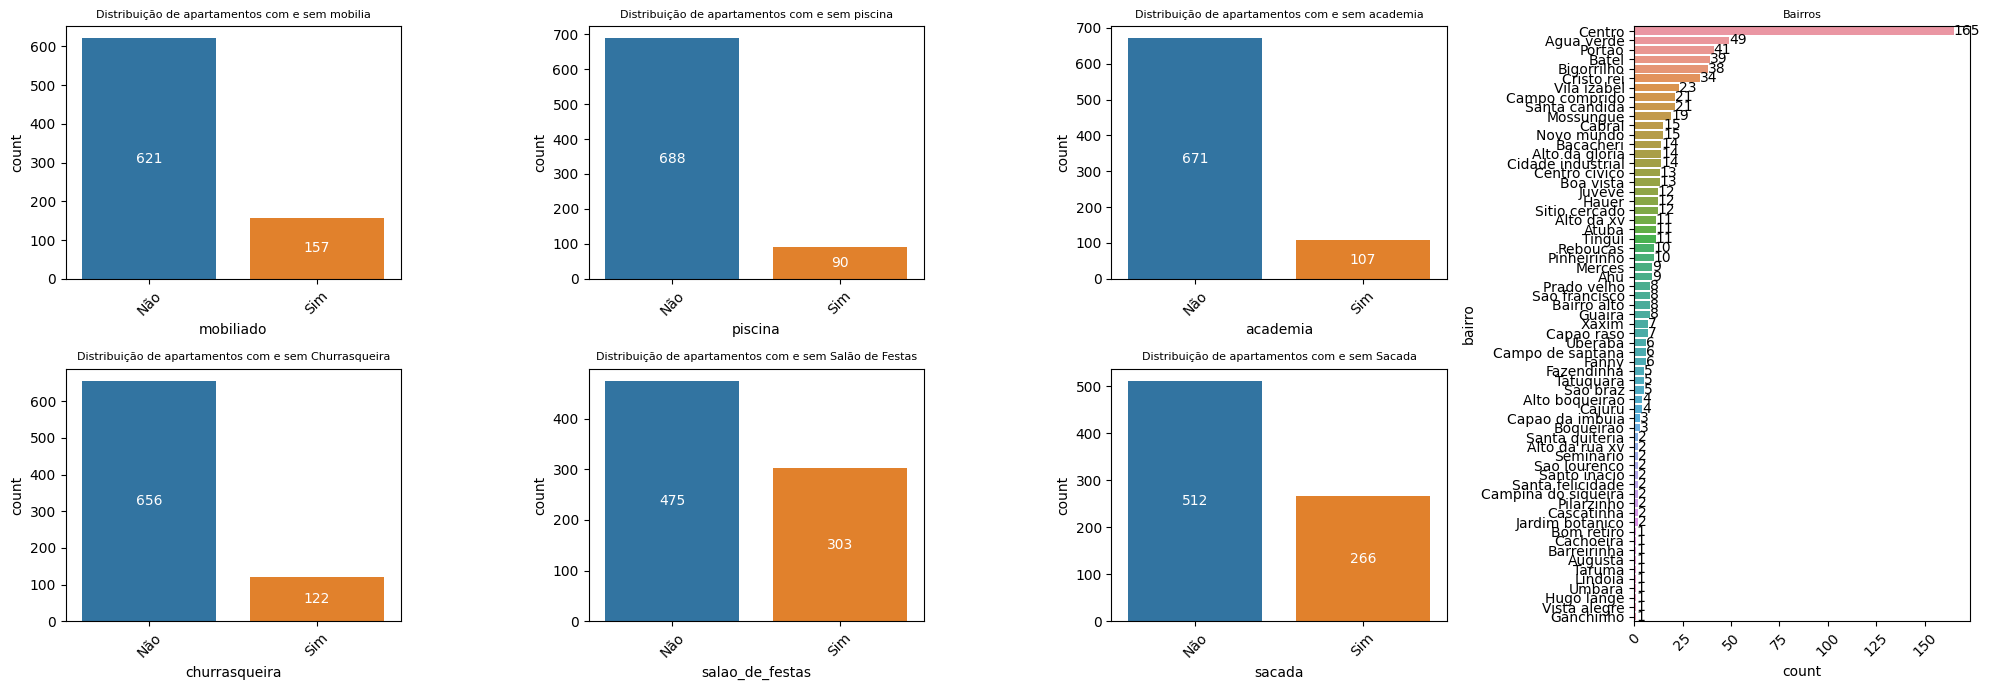

In [702]:
grid = gridspec.GridSpec(2,4)
plt.figure(figsize=(20,7))

f1 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem mobilia',
        title_font_size=8,
        group='mobiliado',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'count',
        data = df,
        figure = f1,
        figsize = grid[0,0],
        sort=False)

f2 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem piscina',
        title_font_size=8,
        group='piscina',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'count',
        data = df,
        figure = f2,
        figsize = grid[0,1],
        sort=False)

f3 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem academia',
        title_font_size=8,
        group='academia',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'count',
        data = df,
        figure = f3,
        figsize = grid[0,2],
        sort=False)

f4 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem Churrasqueira',
        title_font_size=8,
        group='churrasqueira',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'count',
        data = df,
        figure = f4,
        figsize = grid[1,0],
        sort=False)

f5 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem Salão de Festas',
        title_font_size=8,
        group='salao_de_festas',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'count',
        data = df,
        figure = f5,
        figsize = grid[1,1],
        sort=False)


f6 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem Sacada',
        title_font_size=8,
        group='sacada',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'count',
        data = df,
        figure = f6,
        figsize = grid[1,2],
        sort=False)

plt.subplot(grid[:,3])

aux = df[['bairro','valor_total']].groupby('bairro').agg('count').reset_index().rename(columns={'valor_total':'count'}).sort_values('count', ascending=False)

plt.title('Bairros', fontsize=8)
g = sns.barplot(x = 'count', y = 'bairro', data = aux)
plt.xticks(rotation = 45)
for i in g.containers:
    g.bar_label(i, color = 'black',label_type='edge')

plt.tight_layout()

## Análise Bivariada

### Bairro

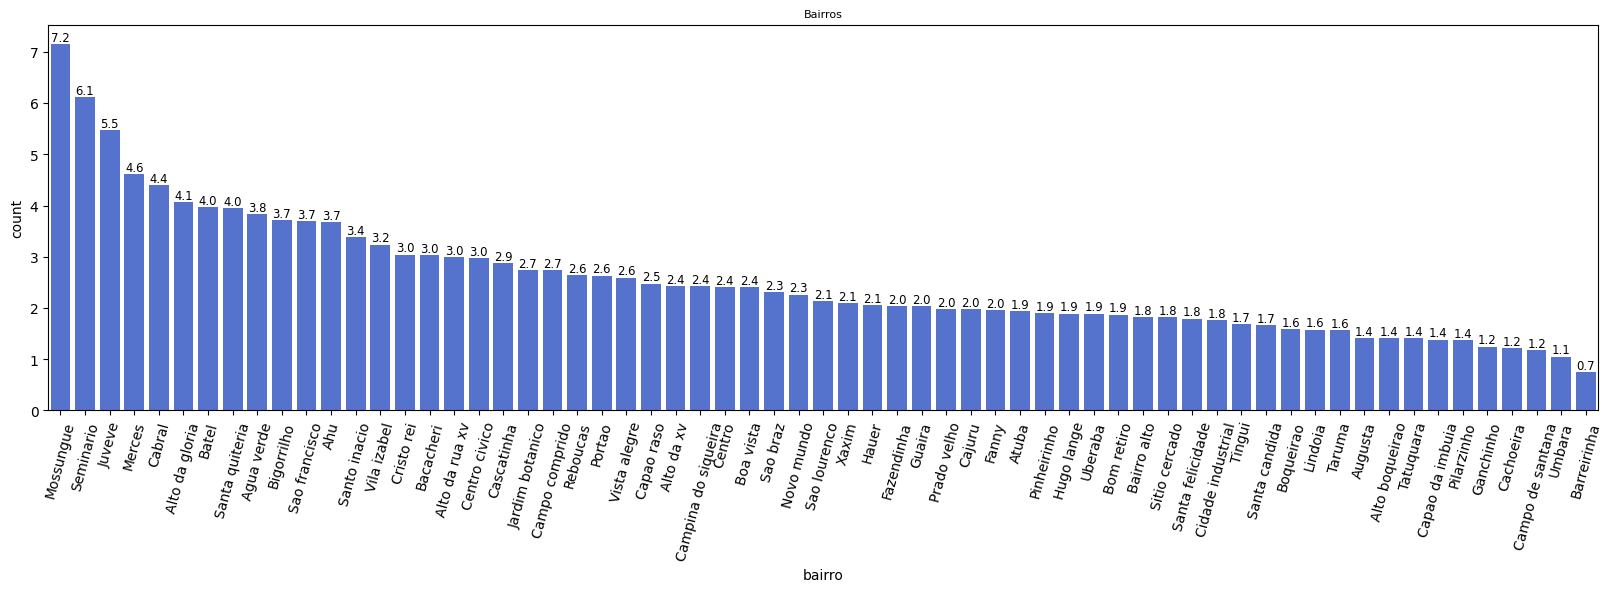

In [703]:
plt.figure(figsize=(20,5))
aux = df[['bairro','valor_total']]
aux['valor_total'] = aux['valor_total']/1000 
aux = aux[['bairro','valor_total']].groupby('bairro').agg('mean').reset_index().rename(columns={'valor_total':'count'}).sort_values('count', ascending=False)

plt.title('Bairros', fontsize=8)
g = sns.barplot(x = 'bairro', y = 'count', data = aux, color='royalblue')
plt.xticks(rotation = 75)
for i in g.containers:
    g.bar_label(i, color = 'black',label_type='edge',fontsize = 'small',fmt='%.1f')

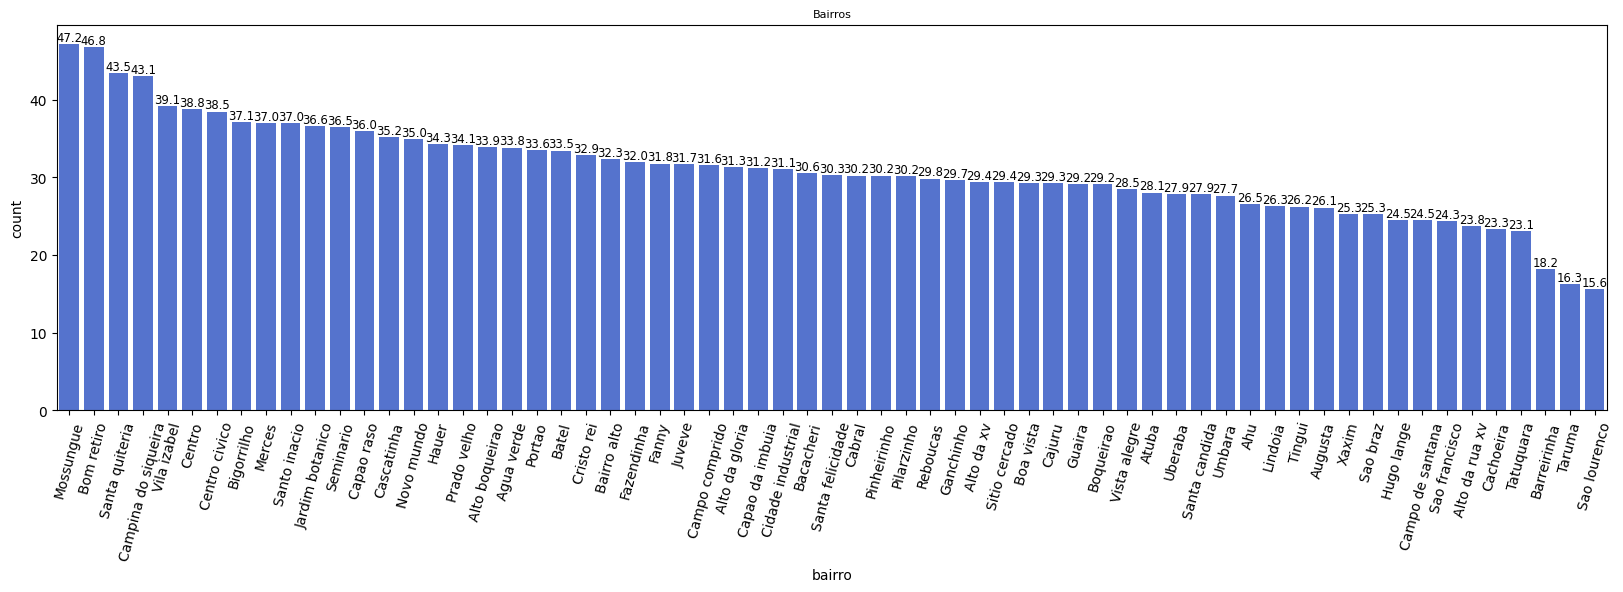

In [704]:
plt.figure(figsize=(20,5))
aux = df[['bairro','preco_metro_2']]
# aux['preco_metro_2'] = aux['preco_metro_2']/1000 
aux = aux[['bairro','preco_metro_2']].groupby('bairro').agg('mean').reset_index().rename(columns={'preco_metro_2':'count'}).sort_values('count', ascending=False)

plt.title('Bairros', fontsize=8)
g = sns.barplot(x = 'bairro', y = 'count', data = aux, color='royalblue')
plt.xticks(rotation = 75)
for i in g.containers:
    g.bar_label(i, color = 'black',label_type='edge',fontsize = 'small',fmt='%.1f')

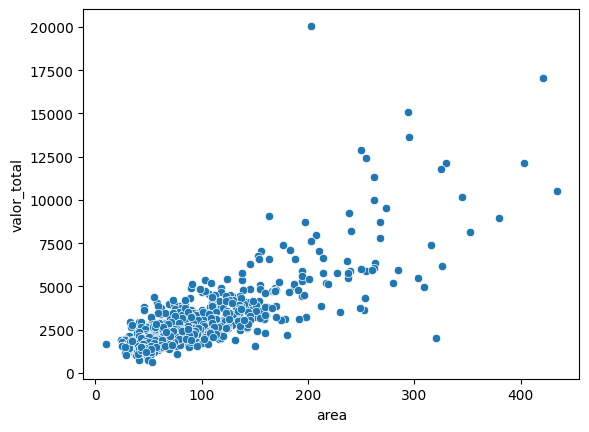

In [705]:
sns.scatterplot(x = 'area', y = 'valor_total', data = df);

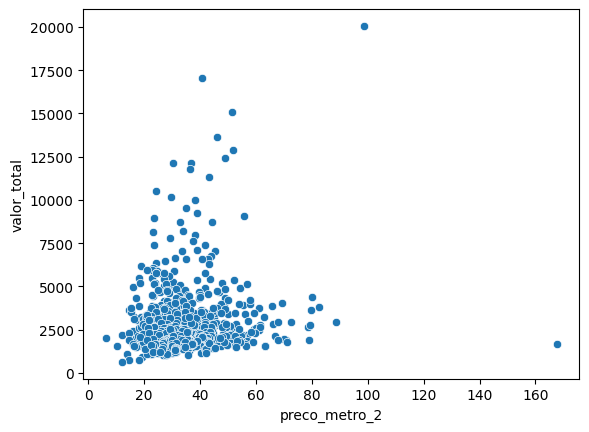

In [706]:
sns.scatterplot(x = 'preco_metro_2', y = 'valor_total', data = df);

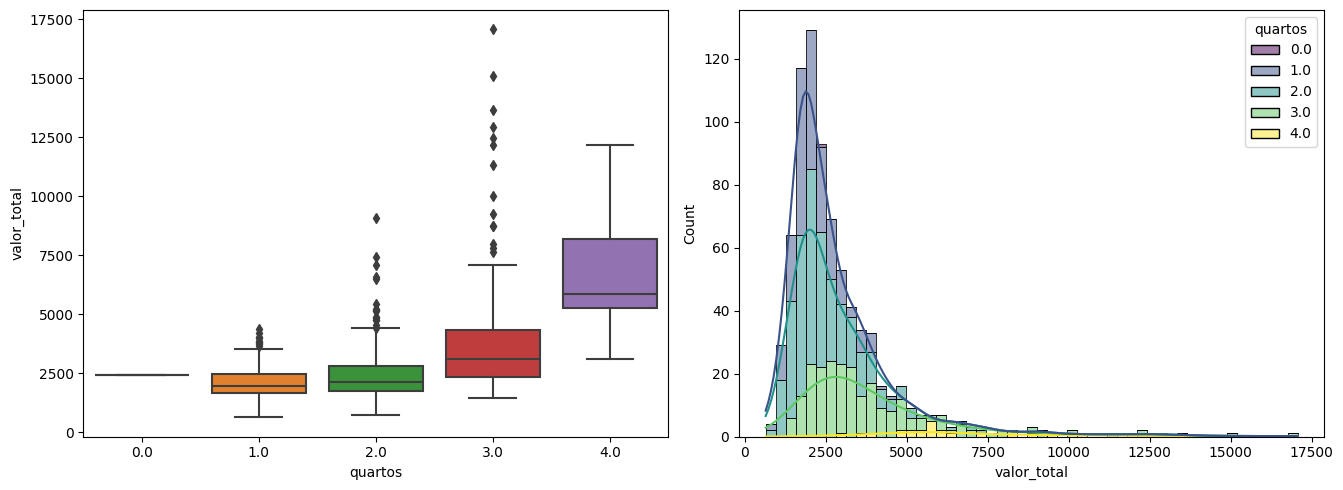

In [707]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='quartos' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'quartos', data=df,multiple = 'stack', palette='viridis', kde = True, fill=True)

plt.tight_layout()

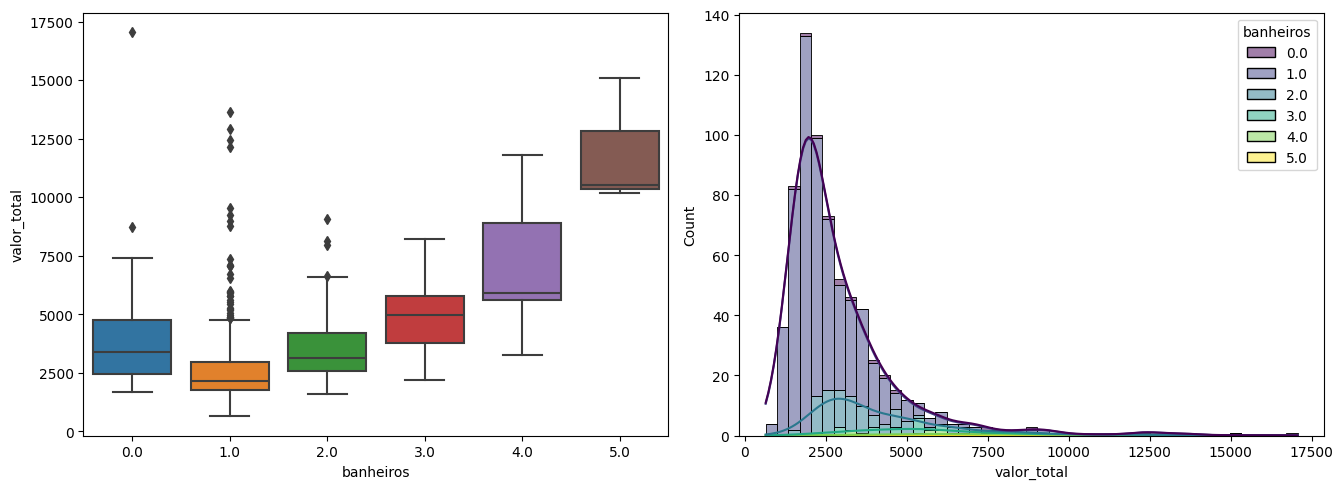

In [708]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='banheiros' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'banheiros', data=df,multiple = 'stack', palette='viridis', kde = True, fill=True)

plt.tight_layout()

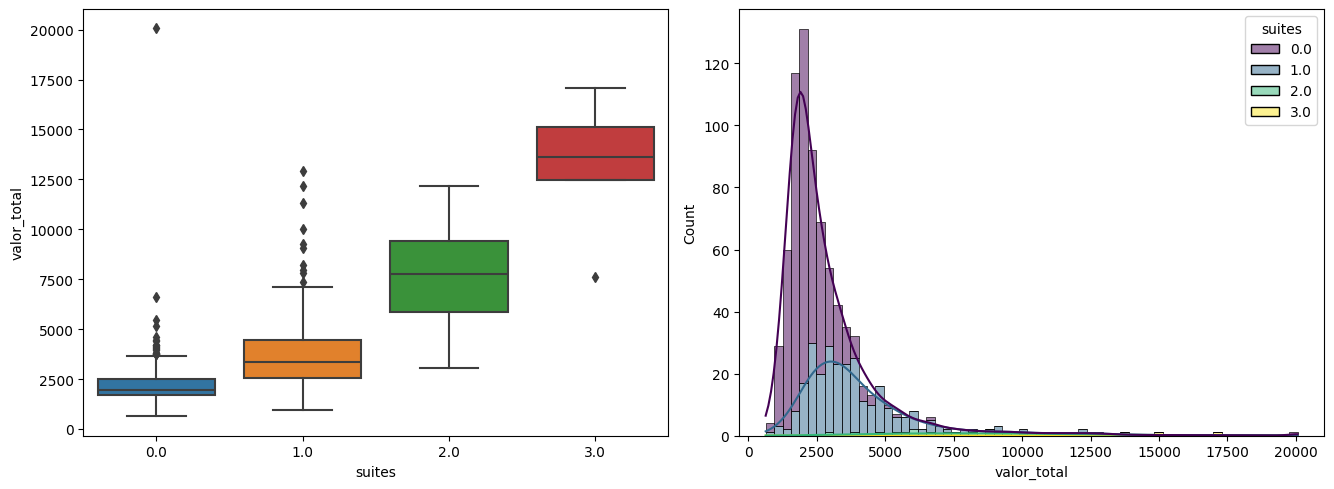

In [709]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='suites' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'suites', data=df,multiple = 'stack', palette='viridis', kde = True, fill=True)

plt.tight_layout()

In [713]:
df.loc[787, 'link']

'https://cilar.com.br/alugar/apartamento-com-1-quarto-centro-curitiba/id/65443581/code/AP0051'

In [711]:
df.loc[df['vagas_garagem'] > 0]

,site,titulo,link,data_coleta,endereco,atributos,descricao,bairro,cidade,aluguel,condominio,seguro_incendio,iptu,area,quartos,suites,banheiros,vagas_garagem,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas,catacteristicas_imovel,detalhes_condominio,valor_total,preco_metro_2
1,Apolar,Apartamento Residencial para Locação no Cristo...,https://www.apolar.com.br/alugar/curitiba/cris...,2024-03-10,"Rua Urbano Lopes, 238, Cristo Rei - Curitiba","250 m², 1 banheiro, 3 vagas, 3 quartos, 1 suit...",Apartamento com 3 quartos no Bairro Cristo Rei...,Cristo rei,Curitiba,12000.0,840.00,71.93,0.00,250.0,3.0,1.0,1.0,3.0,Sim,Não,Sim,Sim,Sim,Sim,NaN,NaN,12911.93,51.647720
2,Apolar,Apartamento Residencial para Locação no Ecovil...,https://www.apolar.com.br/alugar/curitiba/ecov...,2024-03-10,"Rua Dep. Heitor Alencar Furtado, 3180, Ecovill...","330 m², 2 vagas, 4 quartos",Apartamento com 4 quartos no Bairro Ecoville I...,Mossungue,Curitiba,10500.0,1549.67,87.58,21.37,330.0,4.0,1.0,NaN,2.0,Não,Não,Não,Não,Não,Não,NaN,NaN,12158.62,36.844303
3,Apolar,Apartamento Residencial para Locação no Mercês...,https://www.apolar.com.br/alugar/curitiba/merc...,2024-03-10,"Avenida Cândido Hartmann, 330, Mercês - Curitiba","163 m², 2 banheiros, 2 vagas, 2 quartos, 1 sui...",Apartamento com 2 quartos no Bairro Mercês Imó...,Merces,Curitiba,7000.0,1690.58,53.19,341.74,163.0,2.0,1.0,2.0,2.0,Não,Não,Sim,Não,Sim,Não,NaN,NaN,9085.51,55.739325
4,Apolar,Apartamento Residencial para Locação no Bigorr...,https://www.apolar.com.br/alugar/curitiba/bigo...,2024-03-10,"Rua Coronel Joaquim Ignácio Taborda Ribas, 864...","103 m², 2 banheiros, 2 vagas, 3 quartos, 1 sui...",Apartamento com 3 quartos no Bairro Bigorrilho...,Bigorrilho,Curitiba,4400.0,915.67,39.14,0.00,103.0,3.0,1.0,2.0,2.0,Não,Não,Sim,Sim,Não,Sim,NaN,NaN,5354.81,51.988447
5,Apolar,Apartamento Residencial para Locação no Bigorr...,https://www.apolar.com.br/alugar/curitiba/bigo...,2024-03-10,"Alameda Júlia Da Costa, 2242, Bigorrilho - Cur...","118 m², 2 banheiros, 1 vaga, 3 quartos, 1 suite",Apartamento com 3 quartos no Bairro Bigorrilho...,Bigorrilho,Curitiba,4200.0,688.11,41.48,0.00,118.0,3.0,1.0,2.0,1.0,Não,Não,Sim,Sim,Sim,Sim,NaN,NaN,4929.59,41.776186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,Cilar,Apartamento com 2 quartos,https://cilar.com.br/alugar/apartamento-com-2-...,2024-03-10,"Ministro Marcos Freire, 131 - São Braz - Curitiba",NaN,NaN,Sao braz,Curitiba,1100.0,0.00,0.00,20.58,40.0,2.0,0.0,1.0,1.0,Não,Não,Não,Não,Não,Não,Imediações: Escritor Jorge Luis Borges e P. Si...,Garagem Coberta,1120.58,28.014500
787,Cilar,Apartamento com 1 quarto,https://cilar.com.br/alugar/apartamento-com-1-...,2024-03-10,"Rua Mariano Torres, 916 - Centro - Curitiba",NaN,NaN,Centro,Curitiba,990.0,300.00,0.00,47.08,43.0,1.0,0.0,1.0,1.0,Não,Não,Não,Sim,Não,Não,Imóvel ensolarado em excelente localização! ...,NaN,1337.08,31.094884
789,Cilar,Apartamento no 6º andar com 1 quarto,https://cilar.com.br/alugar/apartamento-no-6-a...,2024-03-10,"Presidente Affonso Camargo, 633 - Cristo Rei -...",NaN,NaN,Cristo rei,Curitiba,950.0,580.00,0.00,0.00,57.0,1.0,0.0,1.0,1.0,Não,Não,Não,Não,Não,Sim,Imediações: Nas proximidades da Rodoviária de ...,"Salão de festas, Garagem Coberta",1530.00,26.842105
790,Cilar,Apartamento no 4º andar com 2 quartos,https://cilar.com.br/alugar/apartamento-no-4-a...,2024-03-10,"R HOWELL LEWIS FRY, 341 - CACHOEIRA - Curitiba",NaN,NaN,Cachoeira,Curitiba,850.0,320.00,0.00,42.25,52.0,2.0,0.0,1.0,1.0,Não,Não,Não,Não,Não,Sim,Belo apartamento situado em uma área estratégi...,"Salão de festas, Playground, Portaria 24h, Gar...",1212.25,23.312500


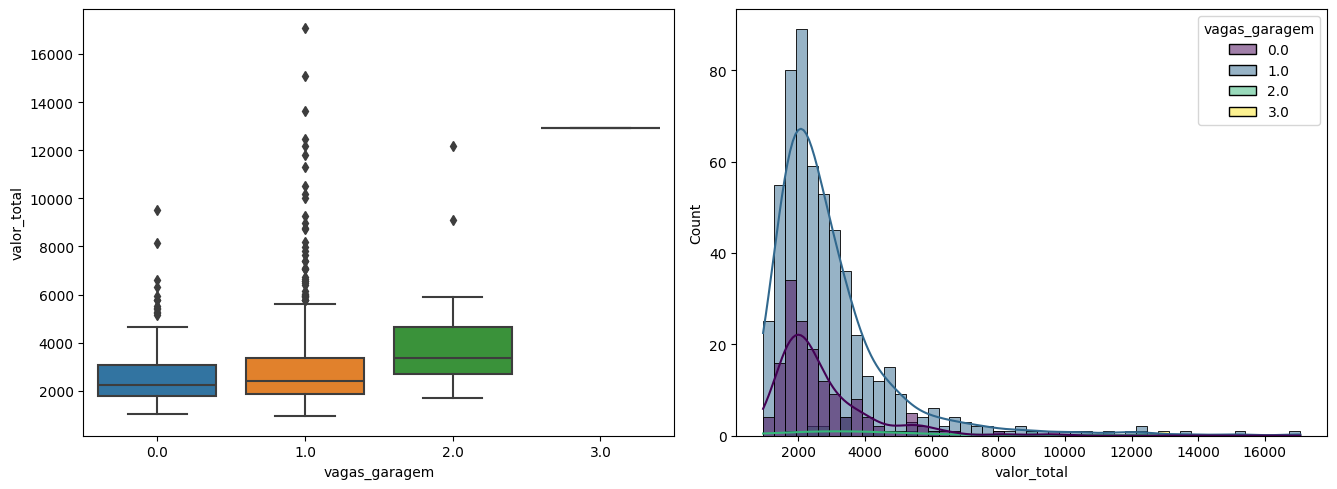

In [710]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='vagas_garagem' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'vagas_garagem', data=df, palette='viridis', kde = True, fill=True)

plt.tight_layout()

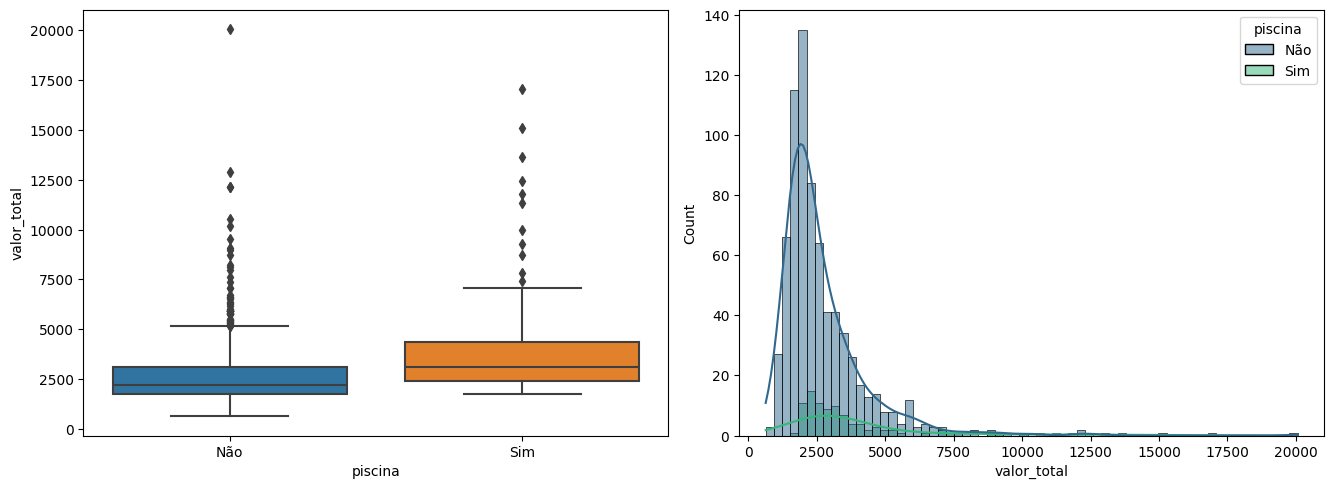

In [123]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='piscina' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'piscina', data=df, palette='viridis', kde = True, fill=True)

plt.tight_layout()

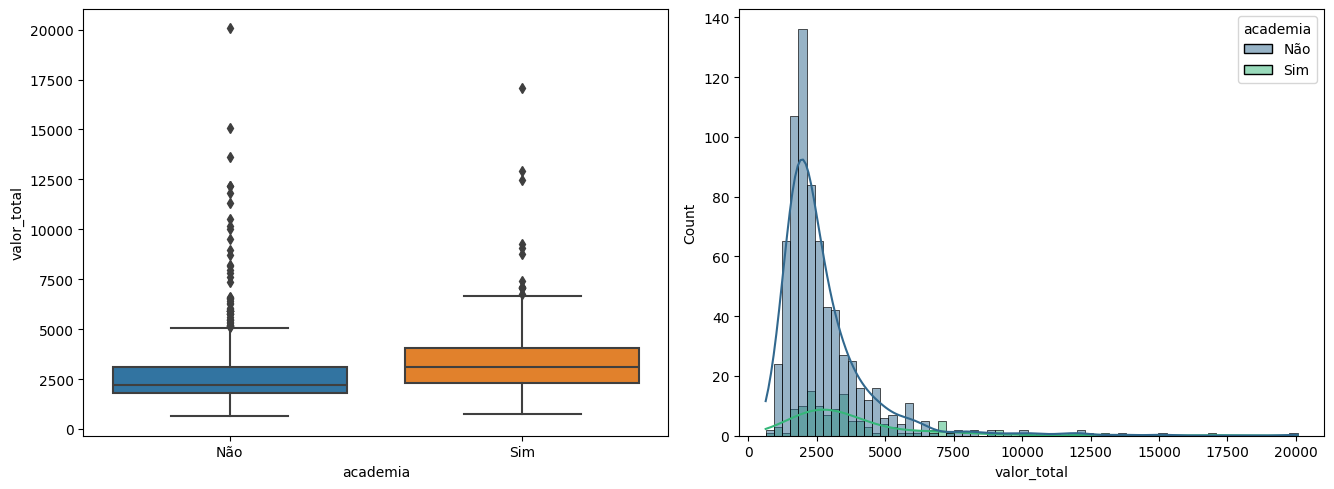

In [124]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='academia' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'academia', data=df, palette='viridis', kde = True, fill=True)

plt.tight_layout()

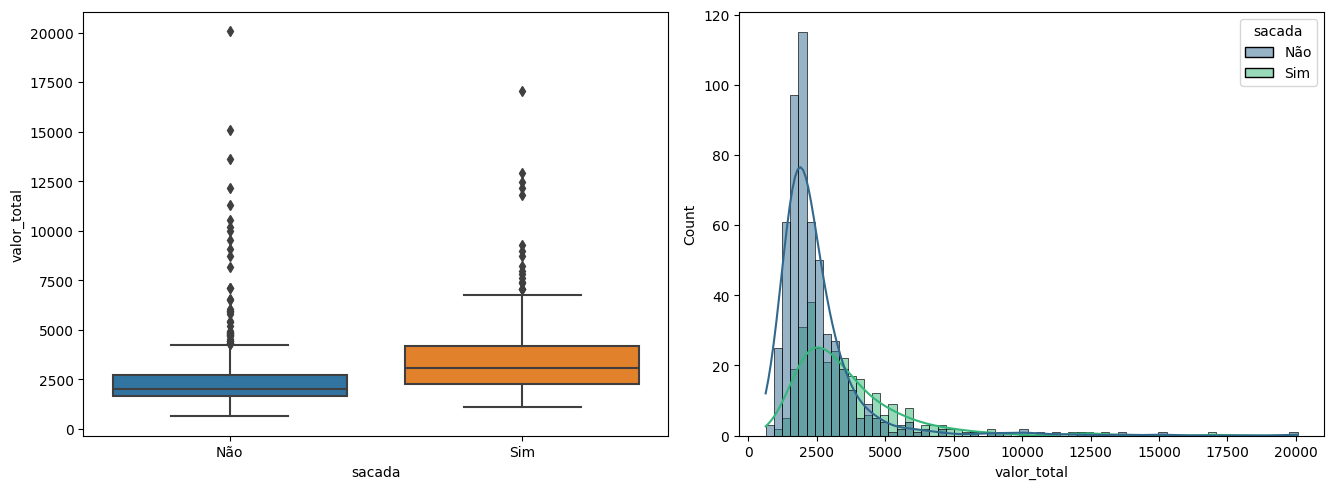

In [125]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='sacada' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'sacada', data=df, palette='viridis', kde = True, fill=True)

plt.tight_layout()

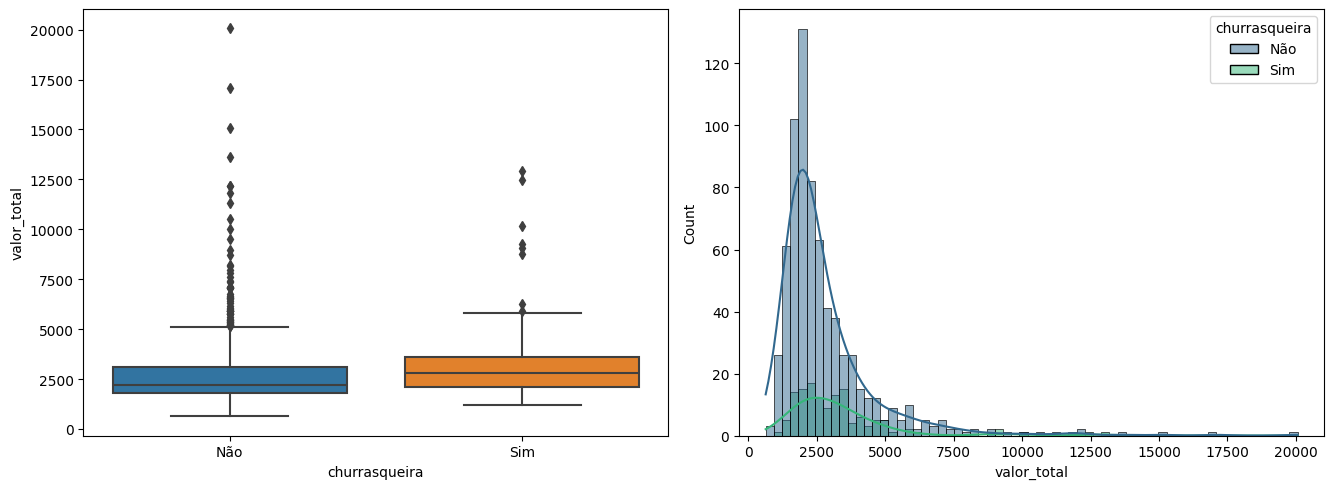

In [126]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='churrasqueira' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'churrasqueira', data=df, palette='viridis', kde = True, fill=True)

plt.tight_layout()

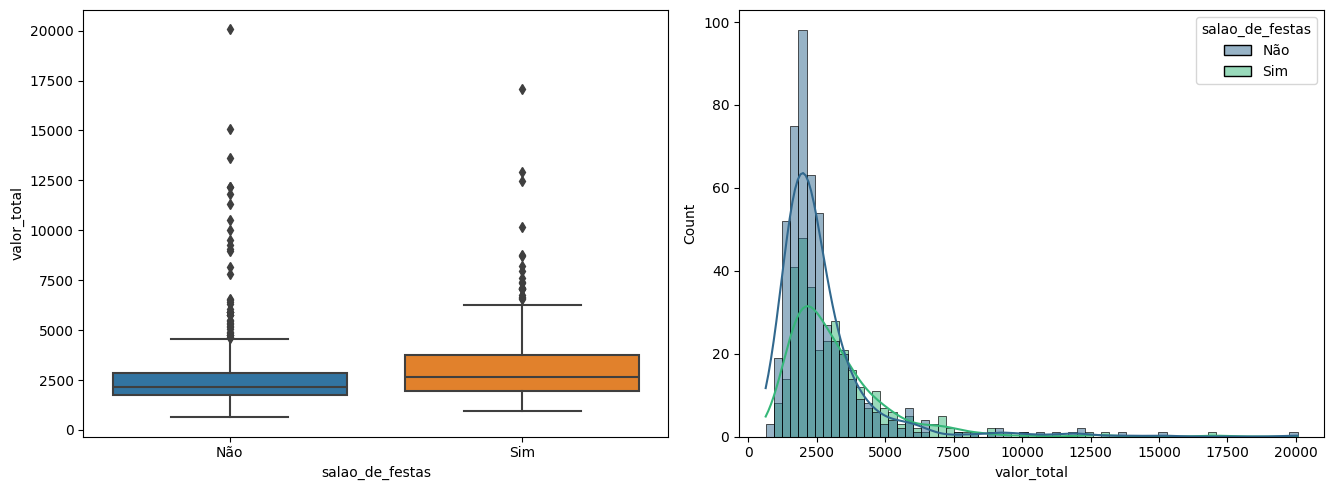

In [128]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='salao_de_festas' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'salao_de_festas', data=df, palette='viridis', kde = True, fill=True)

plt.tight_layout()

In [129]:
df.columns

Index(['site', 'titulo', 'link', 'data_coleta', 'endereco', 'atributos',
       'descricao', 'bairro', 'cidade', 'aluguel', 'condominio',
       'seguro_incendio', 'iptu', 'area', 'quartos', 'suites', 'banheiros',
       'vagas_garagem', 'mobiliado', 'piscina', 'academia', 'sacada',
       'churrasqueira', 'salao_de_festas', 'catacteristicas_imovel',
       'detalhes_condominio', 'Bairro', 'Área (km²)', 'Homens', 'Mulheres',
       'Total', 'Domicilios particulares',
       'Rendimento mensal médio porresponsáveis dos domicílios (R$)',
       'valor_total', 'preco_metro_2'],
      dtype='object')

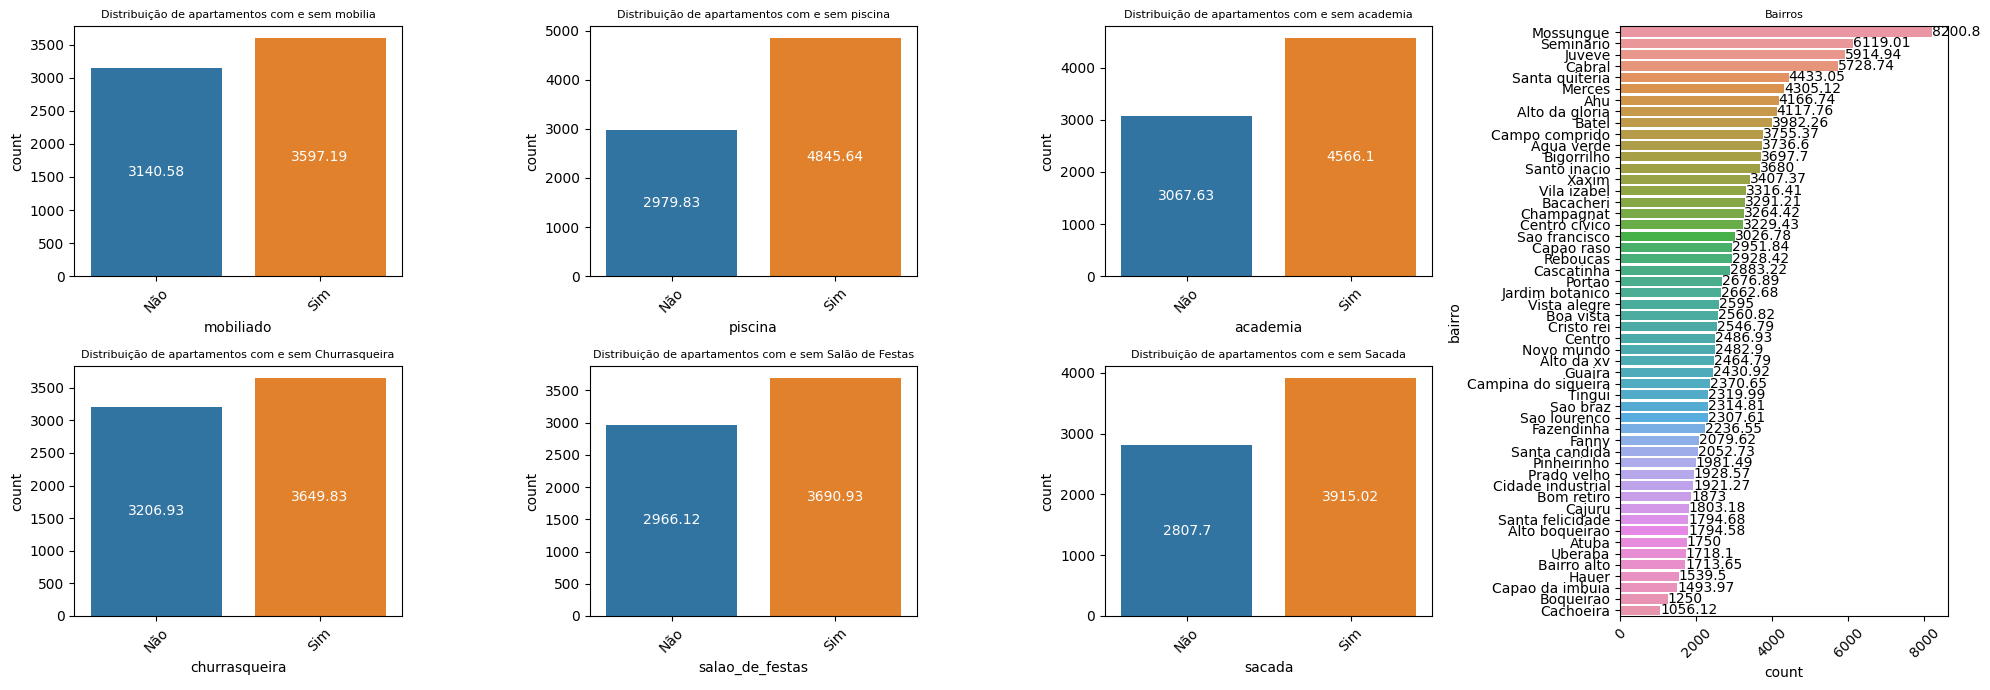

In [27]:
grid = gridspec.GridSpec(2,4)
plt.figure(figsize=(20,7))

f1 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem mobilia',
        title_font_size=8,
        group='mobiliado',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'mean',
        data = df,
        figure = f1,
        figsize = grid[0,0],
        sort=False)

f2 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem piscina',
        title_font_size=8,
        group='piscina',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'mean',
        data = df,
        figure = f2,
        figsize = grid[0,1],
        sort=False)

f3 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem academia',
        title_font_size=8,
        group='academia',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'mean',
        data = df,
        figure = f3,
        figsize = grid[0,2],
        sort=False)

f4 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem Churrasqueira',
        title_font_size=8,
        group='churrasqueira',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'mean',
        data = df,
        figure = f4,
        figsize = grid[1,0],
        sort=False)

f5 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem Salão de Festas',
        title_font_size=8,
        group='salao_de_festas',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'mean',
        data = df,
        figure = f5,
        figsize = grid[1,1],
        sort=False)


f6 = plt.subplot
barplot(title='Distribuição de apartamentos com e sem Sacada',
        title_font_size=8,
        group='sacada',
        agg='valor_total', 
        agg_name = 'count',
        agg_func = 'mean',
        data = df,
        figure = f6,
        figsize = grid[1,2],
        sort=False)

plt.subplot(grid[:,3])

aux = df[['bairro','valor_total']].groupby('bairro').agg('mean').reset_index().rename(columns={'valor_total':'count'}).sort_values('count', ascending=False)

plt.title('Bairros', fontsize=8)
g = sns.barplot(x = 'count', y = 'bairro', data = aux)
plt.xticks(rotation = 45)
for i in g.containers:
    g.bar_label(i, color = 'black',label_type='edge')


plt.tight_layout()

In [35]:
features = [
 'link',
 'bairro',
 'aluguel',
 'condominio',
 'seguro_incendio',
 'iptu',
 'valor_total',
 'area',
 'quartos',
 'suites',
 'banheiros',
 'vagas_garagem',
 'mobiliado',
 'piscina',
 'academia',
 'sacada',
 'churrasqueira',
 'salao_de_festas'
]

In [23]:
import seaborn as sns
%matplotlib inline

In [74]:

aux1['bairro'] = df['valor_total'] / df['area']

0      98.830345
1      51.647720
2      36.779545
3      56.710245
4      53.035047
         ...    
854    26.307500
855    29.450000
856    31.725385
857          inf
858    32.394571
Length: 859, dtype: float64

In [79]:
aux = df[['bairro','valor_total','area']]
aux['preco_por_metro_2'] = df['valor_total'] / df['area']
aux1 = aux[['bairro','preco_por_metro_2']].groupby('bairro').mean().reset_index().sort_values('preco_por_metro_2', ascending = False)


/tmp/ipykernel_278668/2131853489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['preco_por_metro_2'] = df['valor_total'] / df['area']
/tmp/ipykernel_278668/2131853489.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux1 = aux[['bairro','preco_por_metro_2']].groupby('bairro').mean().reset_index().sort_values('preco_por_metro_2', ascending = False)


,bairro,valor_total,area
0,Agua verde,20062.56,203
1,Cristo rei,12911.93,250
2,Ecoville,12137.25,330
3,Merces,9243.77,163
4,Guabirotuba,5674.75,107
...,...,...,...
854,Cristo rei,1367.99,52
855,Bairro alto,1178.00,40
856,Centro,824.86,26
857,Centro,1173.00,0


In [150]:
bairros = df[['bairro','valor_total']].groupby('bairro').count().reset_index()
bairros = bairros.loc[aux['valor_total'] > 10,'bairro'].tolist()

/tmp/ipykernel_278668/1698095510.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bairros = df[['bairro','valor_total']].groupby('bairro').count().reset_index()


/tmp/ipykernel_278668/1020581514.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_bairros = agg_bairros[['bairro','preco_metro_2']].groupby('bairro').mean().reset_index()
/home/arthur/anaconda3/envs/busca-apartamentos-env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


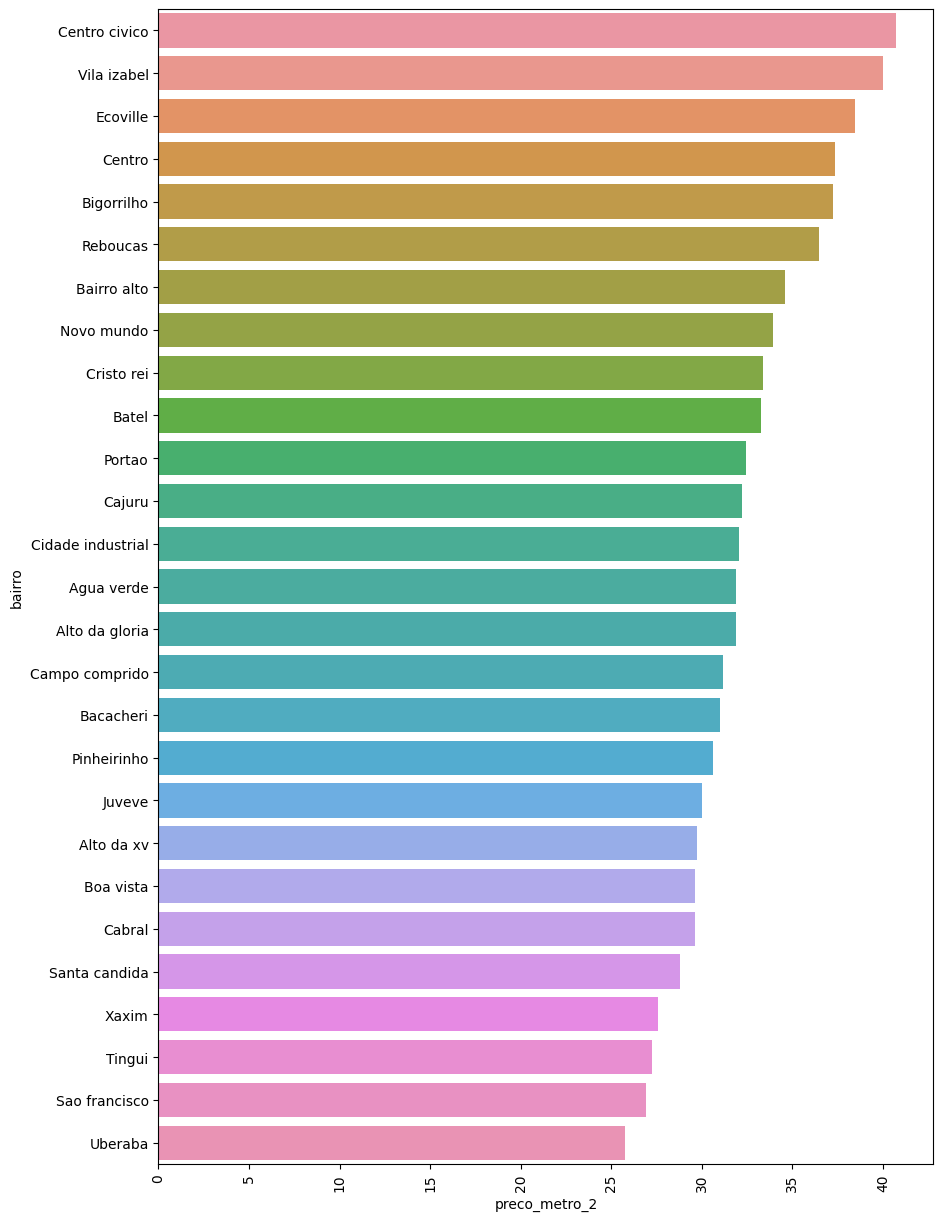

In [152]:
agg_bairros = df.loc[df['area'] > 5 , ['bairro','valor_total','area']]
agg_bairros['preco_metro_2'] = agg_bairros['valor_total'] / agg_bairros['area']
agg_bairros = agg_bairros[['bairro','preco_metro_2']].groupby('bairro').mean().reset_index()
agg_bairros = agg_bairros.loc[agg_bairros['bairro'].isin(bairros)].sort_values('preco_metro_2', ascending=False)

plt.figure(figsize = (10,15))
sns.barplot(y = 'bairro', x = 'preco_metro_2', data = agg_bairros, order=agg_bairros['bairro'])
plt.xticks(rotation = 90);

In [137]:
df.loc[df['bairro'].isin(bairros),['bairro','valor_total']].groupby('bairro').

,bairro,valor_total
0,Agua verde,20062.56
1,Cristo rei,12911.93
2,Ecoville,12137.25
5,Cristo rei,5144.43
6,Bigorrilho,5354.81
...,...,...
854,Cristo rei,1367.99
855,Bairro alto,1178.00
856,Centro,824.86
857,Centro,1173.00


/tmp/ipykernel_278668/2757984633.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = aux[['bairro','preco_por_metro_2']].groupby('bairro').mean().reset_index().sort_values('preco_por_metro_2', ascending = False)
/home/arthur/anaconda3/envs/busca-apartamentos-env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


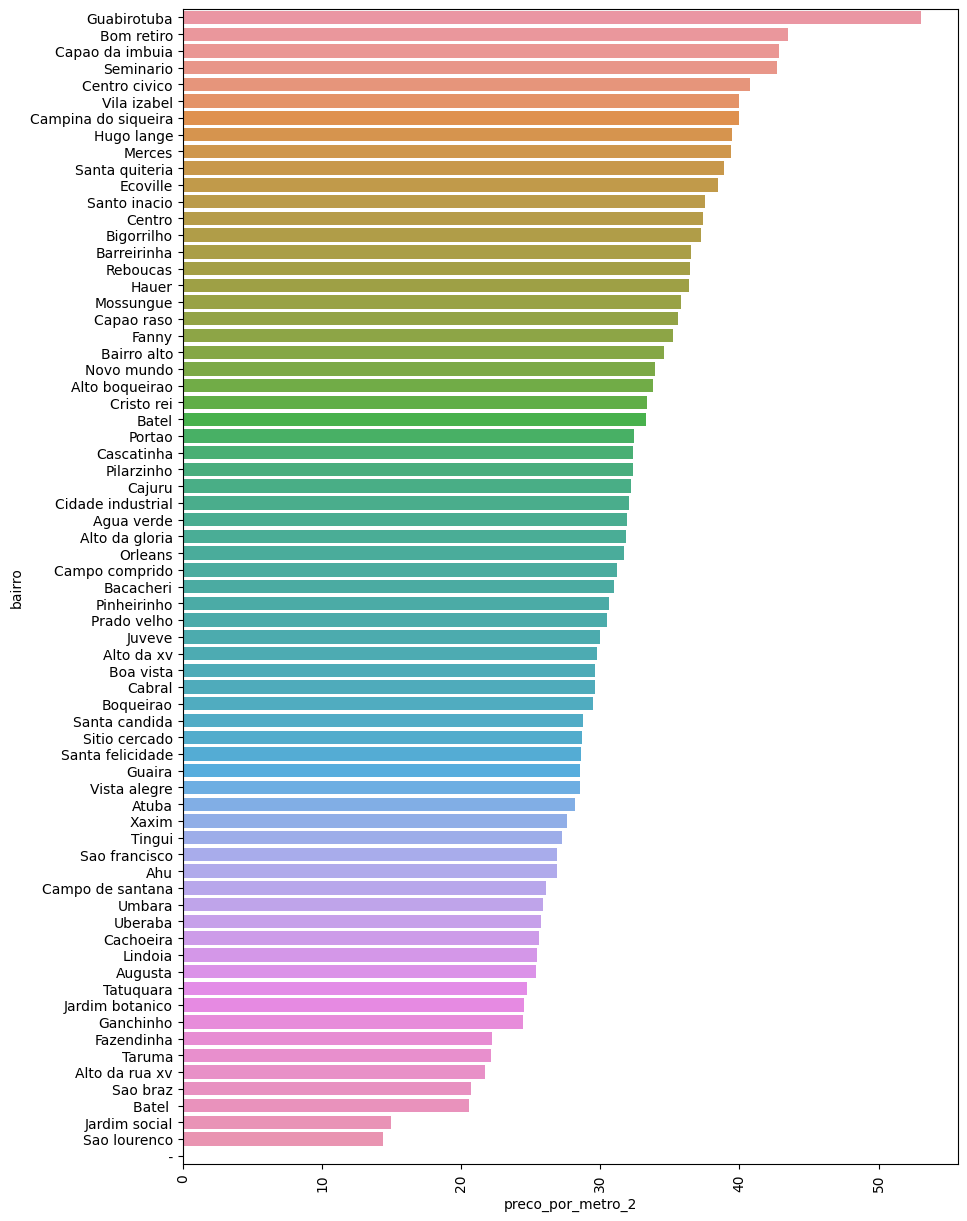

In [91]:
aux = df.loc[df['area'] > 20, ['bairro','valor_total','area']]
aux['preco_por_metro_2'] = df['valor_total'] / df['area']
aux = aux[['bairro','preco_por_metro_2']].groupby('bairro').mean().reset_index().sort_values('preco_por_metro_2', ascending = False)
plt.figure(figsize = (10,15))
sns.barplot(y = 'bairro', x = 'preco_por_metro_2', data = aux, order=aux['bairro'])
plt.xticks(rotation = 90);

In [ ]:
df[['bairro','valor_total','area']]

/tmp/ipykernel_278668/1883961416.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = df[['bairro','area']].groupby('bairro').mean().reset_index().sort_values('area', ascending = False)
/home/arthur/anaconda3/envs/busca-apartamentos-env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


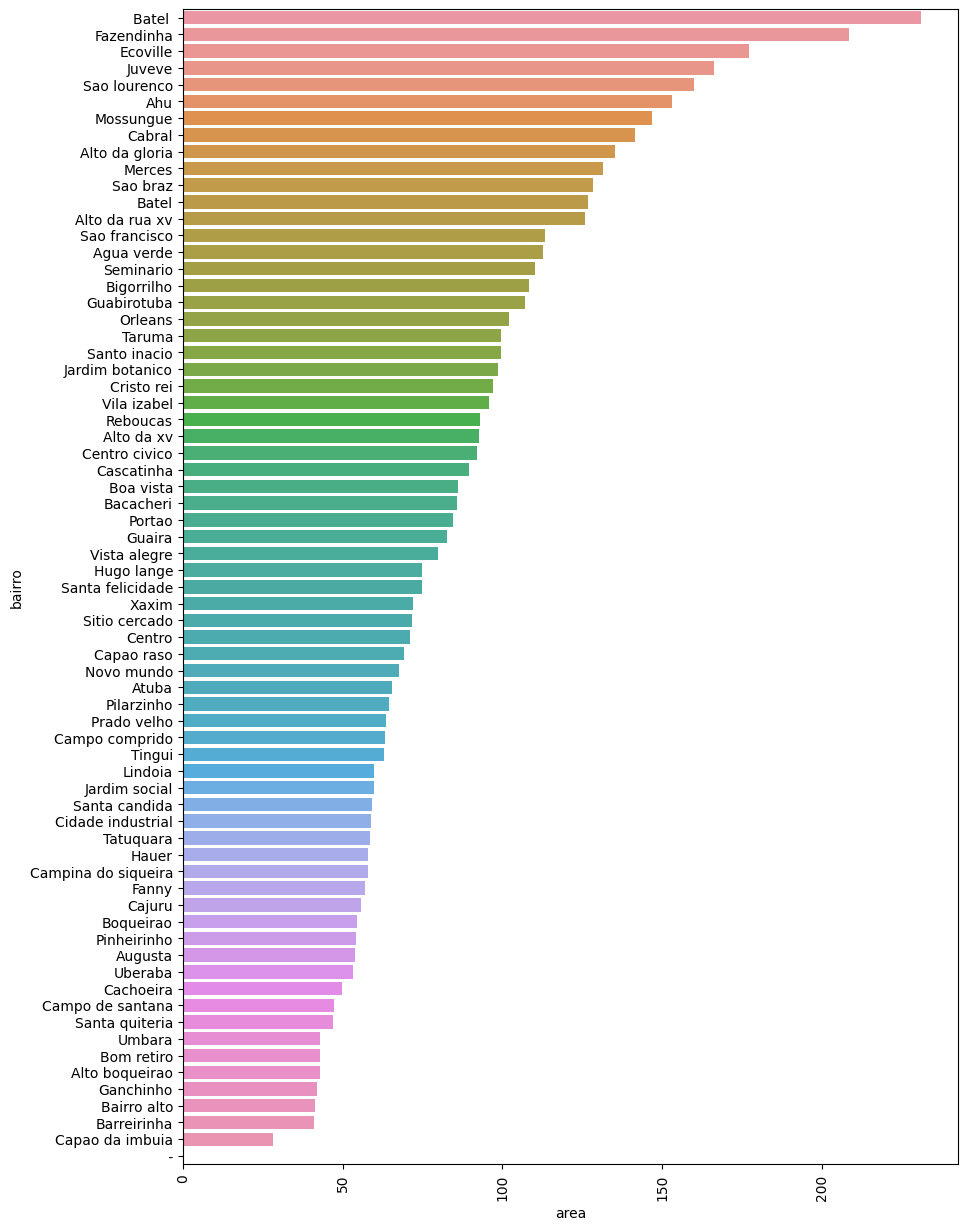

In [71]:
aux = df[['bairro','area']].groupby('bairro').mean().reset_index().sort_values('area', ascending = False)
plt.figure(figsize = (10,15))
sns.barplot(y = 'bairro', x = 'area', data = aux, order=aux['bairro'])
plt.xticks(rotation = 90);

/tmp/ipykernel_278668/311151116.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = df[['bairro','valor_total']].groupby('bairro').mean().reset_index().sort_values('valor_total', ascending = False)
/home/arthur/anaconda3/envs/busca-apartamentos-env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


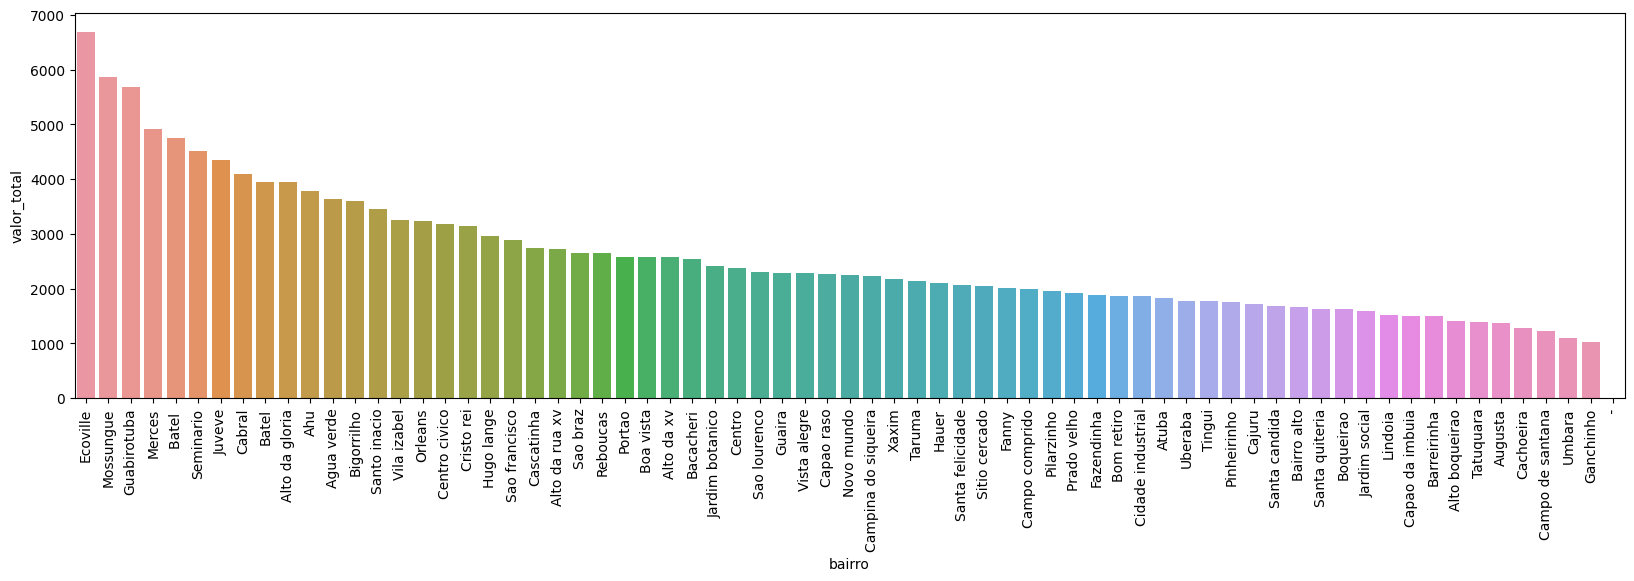

In [68]:
aux = df[['bairro','valor_total']].groupby('bairro').mean().reset_index().sort_values('valor_total', ascending = False)
plt.figure(figsize = (20,5))
sns.barplot(x = 'bairro', y = 'valor_total', data = aux, order=aux['bairro'])
plt.xticks(rotation = 90);